In [1]:
import qiskit.aqua.operators as opAqua
from qiskit.circuit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.quantum_info.operators as opTerra
from qiskit.providers.aer.extensions import snapshot_expectation_value
from qiskit.extensions import HamiltonianGate
from qiskit import Aer, execute

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from itertools import permutations

backend = Aer.get_backend('qasm_simulator')

# 1. Architecture générale

Le code ci-dessous définit la fonction appelée pour l'exécution de l'algorithme. Il constitue donc le corps du programme car c'est ici que les différentes composantes du code sont assemblées.

On peut schématiser son fonctionnement comme suit :
- On commence par créer un circuit 'virtuel' du QAOA tel qu'illustré dans la figure 1 du rapport intermédiaire en le paramétrant avec des paramètres $\gamma$ et $\beta$ (qui n'ont pas encore été optimisés).
- On définit une fonction qui, pour un jeu de paramètres donné, construit réellement le circuit et calcule la moyenne de l'opérateur de coûts en sortie.
- On optimise cette fonction via une fonction de minimisation classique, ce qui nous donne les paramètres optimaux.
- On construit réellement le circuit du QAOA avec ces paramètres et on l'exécute.

In [2]:
def TspQaoa(n, p, weightList, shots = 1000000):

    # Calcul de la taille du registre quantique correspondant aux arêtes de notre graphe -----------------
    
    N = n * (n - 1) // 2
    
    # Construction de l'hamiltonien de coûts, via une fonction qui sera détaillée en partie 2 -------------
    
    HCost = buildCost(n, weightList)
    
    # Initialisation des paramètres gamma et beta, permettant la définition ------------------------------
    # d'un circuit paramétré, via une fonction détaillée en partie 3
    
    parBeta, parGamma = param(p)
    circuit = buildQaoaCircuit(n, p, HCost)

    ''' Nous disposons du circuit du QAOA avec des paramètres qui n'ont pas encore été optimisés.
        Il reste donc à calculer ces paramètres optimaux, ce que nous allons faire via une fonction
        d'optimisation classique qui minimisera la moyenne de l'opérateur de coûts en sortie du circuit,
        en faisant varier les paramètres dans [0, pi]^p x [0, 2*pi]^p (conformément à ce qui est détaillé
        dans la page 3 de l'article de 2014 Farhi et Goldstone). Pour cela, nous commençons par ajouter
        au circuit un bloc destiné au calcul de cette valeur moyenne de l'opérateur via la fonction 
        'snapshot_expectation_value'. '''
    
    # Ajout d'un bloc pour le calcul de la moyenne de l'opérateur de coûts : ------------------------------
    
    HCostTerra = opTerra.Operator(HCost.to_matrix())
    circuit.snapshot_expectation_value('Cost', HCostTerra, range(N))
    
    # Calcul des paramètres optimaux : -------------------------------------------------------------------
    
    initX = 2 * np.pi * np.random.random(2 * p) # Génération aléatoire de l'état initial pour la minimisation
    
    ''' L'optimisation porte sur la fonction 'qaoaCost', détaillée en partie 4, qui, étant donné des paramètres,
        construit un circuit 'réel' à partir du circuit paramétré et renvoie la valeur moyenne de l'opérateur de
        coûts en sortie de ce circuit. '''
    
    resultOpt = opt.minimize(qaoaCost, x0 = initX, options = {'maxiter': 20000, 'disp': False}, args = (circuit, p), bounds = [(0, 2 * np.pi)] * 2 * p) 
    listOptBeta, listOptGamma = resultOpt.x[:p], resultOpt.x[p:] # Récupération des paramètres optimaux
    
    # Création 'réelle' du circuit du QAOA pour les paramètres optimaux ----------------------------------

    optCircuit = circuit.bind_parameters({parBeta: listOptBeta, parGamma: listOptGamma})
    
    # Exécution sur un simulateur ------------------------------------------------------------------------
    
    optCircuit.measure_all() # Rajout d'un registre classique pour réaliser la mesure
    results = execute(optCircuit, backend, shots = shots).result()
    
    return results.get_counts(optCircuit)

# 2. Construction de l'opérateur de coûts

Définition des opérateurs $\hat x_k$ qui serviront à construire l'hamiltonien $\hat H_1 = \sum_{k=0}^{N-1} W_k \hat x_k$ défini en fin de page 14 du rapport intermédiaire :

In [3]:
dictI, dictZ, dictXHat = {}, {}, {}
def I(N):
    if not N in dictI:
        dictI[N] = opAqua.I ^ N
    return dictI[N]

def Z(N, b):
    if not (N, b) in dictZ:
        dictZ[(N, b)] = I(N - b - 1) ^ opAqua.Z ^ I(b)
    return dictZ[(N, b)]

def xHat(N, b):
    if not (N, b) in dictZ:
        dictXHat[(N, b)] = 0.5 * (I(N) - Z(N, b))
    return dictXHat[(N, b)]

Définition de l'hamiltonien de coût $H = H_1 + H_2$ conformément à la page 15 du rapport intermédiaire.

In [4]:
def buildCost(n, weightList):
    N = n * (n - 1) // 2
    H_1 = 0
    for b in range(N):
        H_1 += weightList[b] * xHat(N, b)

    H_2 = opInvalid(n)
    return H_1 + 2 * np.sum(weightList) * H_2

Définition de la fonction 'opInvalid' permettant de construire $H_2 = \sum_x (1-isValide(x))|x><x|$.

In [5]:
dictOpInvalid = {}

def opInvalid(n):
    if not n in dictOpInvalid:
        diagonal = []
        N = n * (n - 1) // 2
        for i in range(2 ** N):
            x = np.binary_repr(i, width = N)
            diagonal.append(1 - isValide(x, n)[0])
        dictOpInvalid[n] = opAqua.MatrixOp(np.diag(diagonal))

    return dictOpInvalid[n]

# La fonction isValide vérifie si une séquence binaire x est bien un chemin possible pour le TSP à n villes

def isValide(x, n):
    N = n * (n - 1) // 2
    tour = []
    Gamma = []
    C = buildC(n)
    for i in range(N):
        if x[i] == '1':
            Gamma.append(C[i])
    if len(Gamma) != n: return 0, x
    S = Gamma.pop().copy()
    k = 0
    while S[k] != 1:
        k +=1
    tour.append(k)
    while 1 in S:
        i = 0
        while i < len(Gamma) and Gamma[i][k] != 1: i += 1
        if i == len(Gamma): return 0, x
        c = Gamma[i]
        for j in range(n):
            if c[j] == 1 and j != k:
                nextk = j
        k = nextk
        tour.append(k)
        S += c
        Gamma.pop(i)
        if max(S) > 2: return 0, x
    if 0 in S: return 0, x
    return 1, tour

def buildC(n):
    C = []
    for i in range(n):
        for j in range(i + 1, n):
            c = np.zeros(n)
            c[i] = 1
            c[j] = 1
            C.append(c)
    return C

# 3. Construction du circuit paramétré

In [6]:
dictParam = {}
def param(p): # Crée la liste des paramètres auxquels on assigne des valeurs plus tard
    if not p in dictParam:
        dictParam[p] = (ParameterVector("Beta", p), ParameterVector("Gamma", p))
    return dictParam[p]

# On crée un circuit générique et on assigne les valeurs de gamma et beta plus tard
def buildQaoaCircuit(n, p, HCost):
    N = n * (n - 1) // 2  # N est le nombre d'arêtes du graphe
    qaoaCircuit = QuantumCircuit(N, name = "Global Circuit")

    initCircuit = QuantumCircuit(N, name = 'Init')
    initCircuit.h(range(N))

    qaoaCircuit.append(initCircuit, range(N))
    qaoaCircuit.barrier()


    def UCost(t): # Fonction d'évolution temporelle associée à l'opérateur de coûts
        circuitUCost = QuantumCircuit(N, name = "U_cost")
        circuitUCost.append(HamiltonianGate(HCost, t), range(N))
        return circuitUCost

    def UDriver(t): # Fonction d'évolution temporelle associée à l'opérateur driver 
        circuitUDriver = QuantumCircuit(N, name = "U_driver")
        circuitUDriver.rx(- 2 * t, range(N))
        return circuitUDriver

    parBeta, parGamma = param(p)

    # On créé le circuit en alternant les Ucost et les UDriver avec les paramètres gammas et betas correspondants

    for k in range(p): 
        qaoaCircuit.append(UCost(parGamma[k]), range(N))
        qaoaCircuit.append(UDriver(parBeta[k]), range(N))
        qaoaCircuit.barrier()

    return qaoaCircuit


# 4. Fonction 'qaoaCost', objet de la minimisation

La fonction 'qaoaCost' renvoie, pour une liste des paramètres betas gammas, un circuit paramétré et une profondeur temporelle, la moyenne de l'opérateur de coûts en sortie du circuit associé.

In [7]:
def qaoaCost(parValue, circuit, p):
    listValBeta, listValGamma = parValue[:p], parValue[p:]
    parBeta, parGamma = param(p) 

    # Construction du circuit 'réel' à partir du circuit paramétré et des paramètres
    
    currentCircuit = circuit.bind_parameters({parBeta: listValBeta, parGamma: listValGamma})

    results = execute(currentCircuit, backend, shots = 1000).result()
    return results.data()['snapshots']['expectation_value']['Cost'][0]['value'].real 

# 5. Execution

Choix du nombre de villes et des poids des arêtes ($N = n(n-1)/2$ arêtes) :

In [8]:
n = 3
weight = [1,1,1]

result = TspQaoa(n, 2, weight)

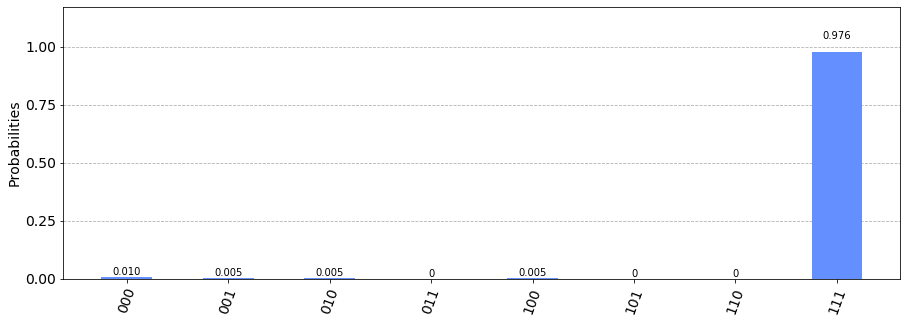

In [9]:
plot_histogram(result, figsize = (15, 5))